# Opportunity Youth in South King County updated with 2017 data

## Import Necessary Packages

In [1]:
from sqlalchemy import create_engine
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import opyouth

## Import Data
Use the associated `opportunity_youth.sql` file in this repository to run postgreSQL queries to retrieve the opportunity youth summary data from the database. Run the following commands in your terminal:

`psql opportunity_youth`

`\i .\opportunity_youth.sql`    <- Make sure this path points to the .sql file in this repository!

The following command will pull the associated data into dataframes to be used in the rest of this Notebook.

In [2]:
(opp_youth,
 total_population, 
 poptotals, 
 opportunity_youth, 
 OYtotals, 
 pivot_total_youth_pop, 
 pivot_opportunity_youth,
 youth_population_2014_2017,
 youth_population_totals_2014_2017, 
 oy_population_2014_2017, 
 oy_population_totals_2014_2017,
 total_youth) = opyouth.pullsqldata()

# Purpose of Analysis

In order to better serve the opportunity youth of South King County, we are updating our statistics on these youth with more current data. We want to enable our services to focus on the population who would benefit the most from our services.

# Key Takeaways

1. The total number and percentage of opportunity youth in S. King Co. lowered between 2014 and 2017. This trend is also repeated across all age groups.

2. Opportunity youth without college experience are more prevalent than those with college experience.

Although our analyses are unable to discern between demographic effects and policy change effects, we are confident that opportunity youth numbers have lowered in S. King Co. We suggest that future service programs focus on helping opportunity youth transition from high school to college.

## Estimating 2017 Opportunity Youth

The estimate of 2019 opportunity youth is calculated by summing all the records from the `pums_2017` database filtered by rows that meet the qualifications for South King County opportunity youth (i.e., ages 16-24 and neither currently enrolled nor employed), but each record is multiplied by the column `pwgtp` which is the weight that record holds for the total population. Here, if we sum `pwgtp` across all the rows, we get an estimate of the number of opportunity youth in South King County for 2017.

In [3]:
print(opp_youth['pwgtp'].sum())

12438.0


## Calculating Opportunity Youth Status by Age

The 2016 report on opportunity youth contains a table showing total opportunity youth and total youth by age, their education status, and their employment status. We recalculate these statistics using the updated information for 2017. To see the original data, see page two in https://roadmapproject.org/wp-content/uploads/2018/09/Opportunity-Youth-2016-Data-Brief-v2.pdf. 

The following tables stored in `pivot_total_youth_pop` and `poptotals` replicate the original tables and show the breakdown of our estimates of South King Co. youth by their age bracket (16-18, 19-21, or 22-24) and their employment/education status (not an Opportunity Youth, an Opportunity Youth, or a youth working without a HS diploma or GED). We also show the percentage that each of these segments makes up of the total youth population. 



In [4]:
pivot_total_youth_pop

estimate                         total            \
age_flag                Age 16-18 Age 19-21 Age 22-24 Age 16-18 Age 19-21   
oy_flag                                                                     
Not OY                    35380.0   26579.0   33253.0   37933.0   32977.0   
OY                         2092.0    4749.0    5597.0   37933.0   32977.0   
Working without diploma     461.0    1649.0    1879.0   37933.0   32977.0   

                                    percent                      
age_flag                Age 22-24 Age 16-18 Age 19-21 Age 22-24  
oy_flag                                                          
Not OY                    40729.0     93.27      80.6     81.64  
OY                        40729.0      5.51      14.4     13.74  
Working without diploma   40729.0      1.22       5.0      4.61

In [5]:
poptotals

,oy_flag,group_total,total_population,percent,year
0,OY,12438.0,111639.0,11.14,2017
1,Not OY,95212.0,111639.0,85.29,2017
2,Working without diploma,3989.0,111639.0,3.57,2017


## Calculating Education Achievement of 2017 Opportunity Youth

The following two tables contain similar statistics as the previous two tables, but divide up the opportunity youth of South King Co. by their level of education: those without a diploma, those with a HS diploma or GED, those with some college credits but no degree, or those with a college degree (associates or higher).

In [6]:
pivot_opportunity_youth

estimate                         total            \
age_flag              Age 16-18 Age 19-21 Age 22-24 Age 16-18 Age 19-21   
edu_flag                                                                  
College Degree Holder       NaN     132.0     633.0       NaN    4749.0   
College but no degree     143.0     624.0    1228.0    2092.0    4749.0   
HS Diploma or GED         833.0    2651.0    2259.0    2092.0    4749.0   
No Diploma               1116.0    1342.0    1477.0    2092.0    4749.0   

                                  percent                      
age_flag              Age 22-24 Age 16-18 Age 19-21 Age 22-24  
edu_flag                                                       
College Degree Holder    5597.0       NaN      2.78     11.31  
College but no degree    5597.0      6.84     13.14     21.94  
HS Diploma or GED        5597.0     39.82     55.82     40.36  
No Diploma               5597.0     53.35     28.26     26.39

In [7]:
OYtotals

,edu_flag,group_total,total_population,percent,year
0,College but no degree,1995.0,12438.0,16.04,2017
1,No Diploma,3935.0,12438.0,31.64,2017
2,HS Diploma or GED,5743.0,12438.0,46.17,2017
3,College Degree Holder,765.0,12438.0,6.15,2017


# Key results from comparing 2017 data to 2014 data

To compare our updated statistics on opportunity youth in South King County, we included four .csv files in this repository that replicate the data from the 2016 report which were imported into dataframes at the beginning of this Notebook. Below, we plot these datasets side-by-side to highly trends between 2014 and 2017.

### The overall youth population has decreased

First, we plot the total number of youths ages 16-24 in the region of interest. We see that there is a drop from approximately 140,000 individuals in the 2014 census to about 115,000 in 2017.

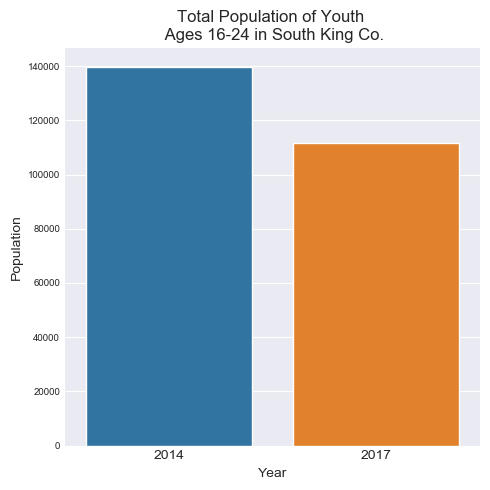

In [8]:
opyouth.plotdata1(youth_population_totals_2014_2017);

### The proportion of opportunity youth in South King Co. has decreased

Taking into consideration that the total number of youths have decreased, we also see that the percentage of 16-24 year olds in South King County that qualify as opportunity youths have also decreased by about one percent. 

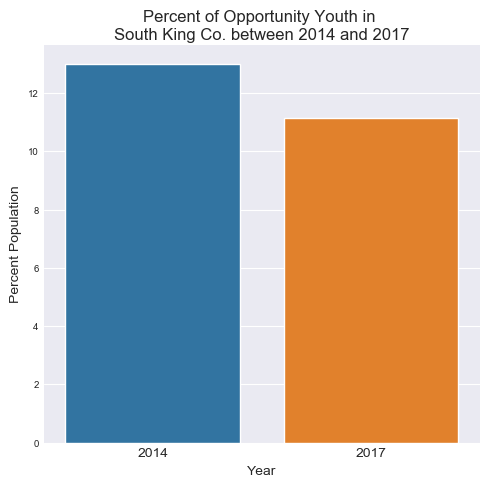

In [9]:
opyouth.plotdata2(df = youth_population_totals_2014_2017);

### The proportion of opportunity youths have decreased across all three age ranges

The following plots show the percentage of the youth population in the three age groups. In the opportunity youth specifically, the percentage has decreased in all three groups, with the largest decrease in 22-24 year olds, which now make up a smaller percentage of opportunity youth than the 19-21 year olds, a reversal from the 2014 data.

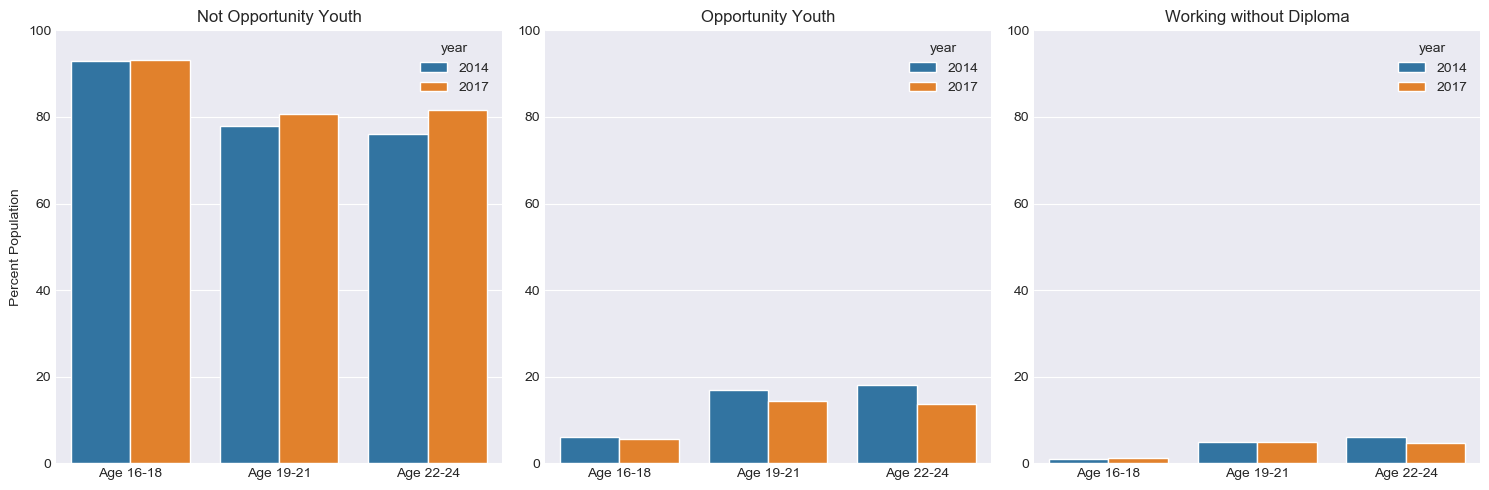

In [10]:
opyouth.plotdata3(df = youth_population_2014_2017);

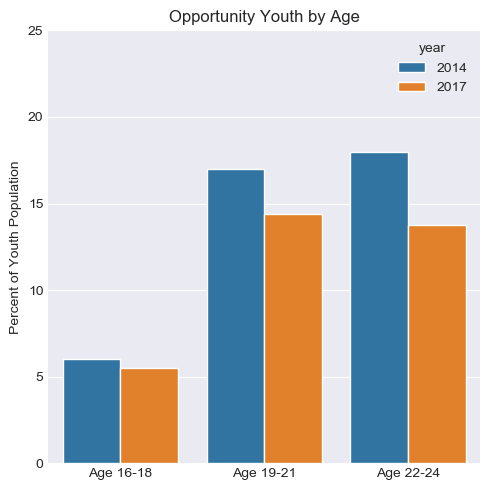

In [11]:
opyouth.plotdata4(df = youth_population_2014_2017);

### The proportion of opportunity youths with college experience has decreased

Finally, we plotted the level of education attained by opportunity youths between 2014 and 2017. Opportunity youths that have not completed any schooling other than high school or their GED have increased in proportion compared to those who have college experience, which have decreased in number since 2014. 

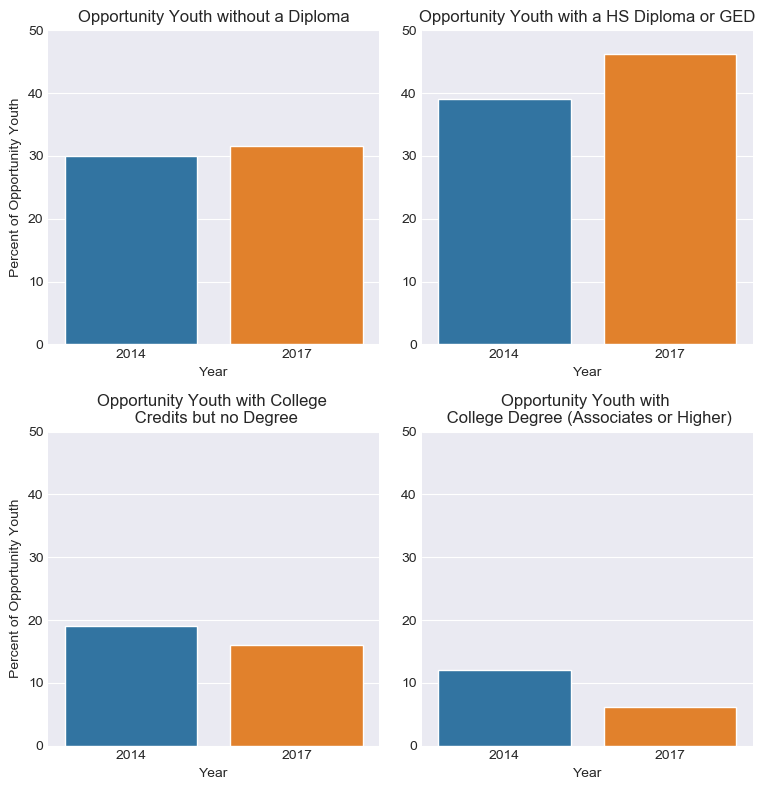

In [12]:
opyouth.plotdata5(df = oy_population_totals_2014_2017);

## Visualizing the Opportunity Youth across South King County


Because population statistics tend to have a spatial dependency, it is important to visualize the Opportunity Youth 
across the South King County region. We were provided shape files for the puma regions that we were studying, so
first we wanted to visualize our defined region. We did this by using the Folium and Geopandas packages which
simplify live map production. The following function creates our live Folium Map displaying the region that we studied. 

In [15]:
opyouth.make_locator_map()

## Visualize the spatial distribution of the Opportunity Youth across South King County

Seeing the region is nice, but it does not add much when trying to interpret trends. Our next step was to visualize the distribution of the OY population across this region. We first call a function that adds the columns to the geopandas dataframe containing: total estimated OY, total youth population, and percent OY. For both of the following maps, we chose to avoid any data classification and instead visualize the population data as continuous. 

In [14]:

s_king_df = opyouth.prepare_df_for_choropleth(opp_youth,total_youth)


Next, we call a function to create a choropleth map visualizing total OY pop by puma region. This map makes it clear that the largest OY populations reside in the southern and western urban areas of Seattle, and Vashon Island. The lowest OY populations reside closer to the center of Seattle, Central District, and Beacon Hill. 

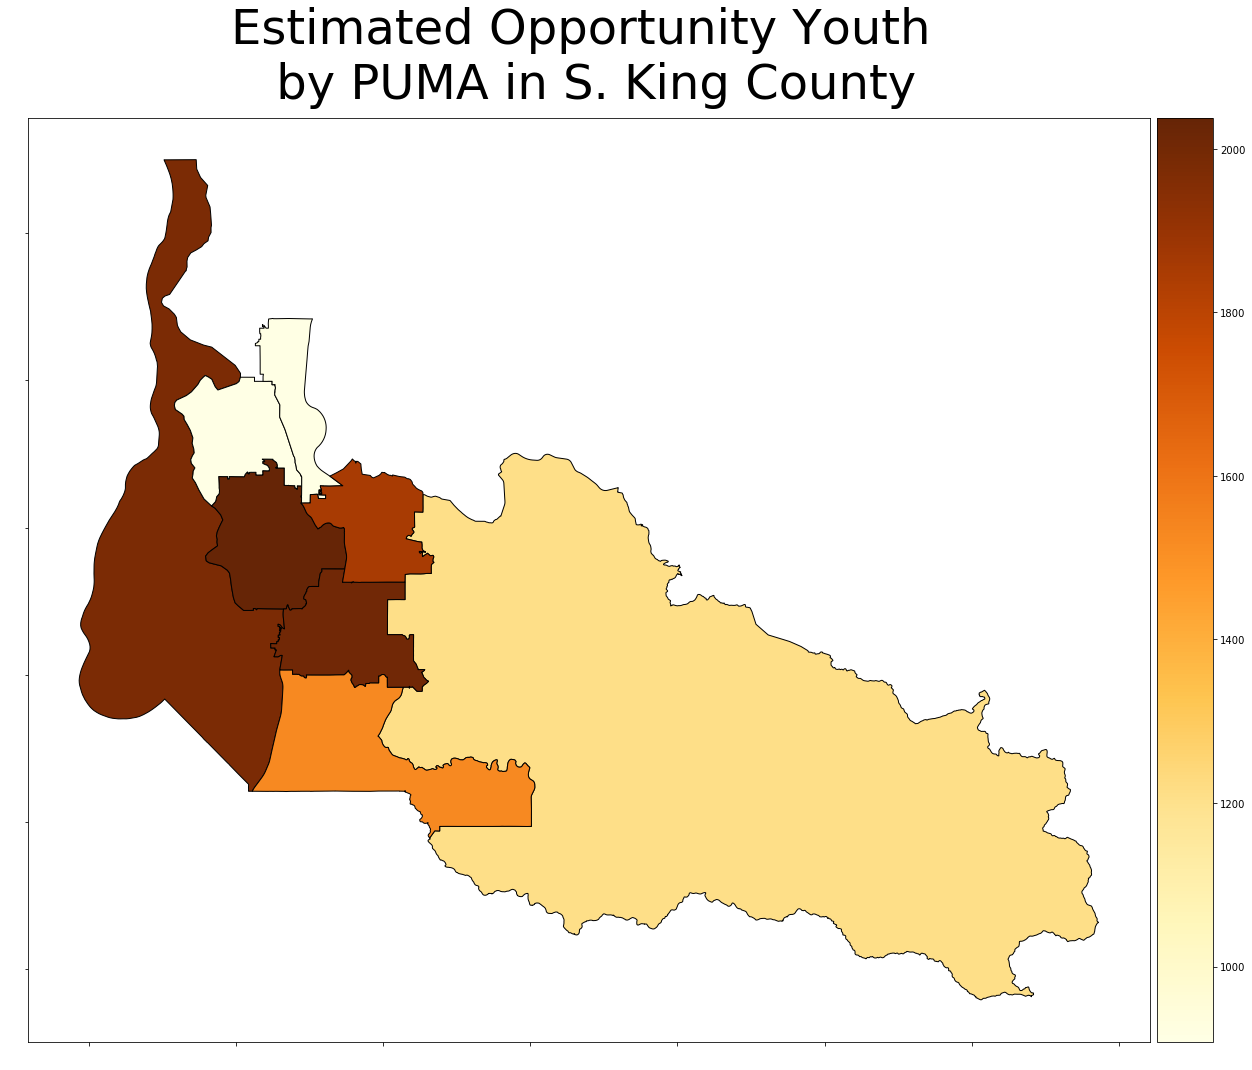

In [11]:
opyouth.make_choropleth_OYpop_map(s_king_df);

Finally, we gain more insight by visualizing the OY percent of total youth population across the region. This is potentially a useful metric for interpretation because in a way it normalizes less and more densely populated regions. For example, we can see that the Maple Valley, Hobart, and Eumenclaw region has a faily high percent of OY despite the relatively low total OY population. We can also see that the Tukwila/South West Seattle puma region has both a high total OY population and a high percent of youth.  

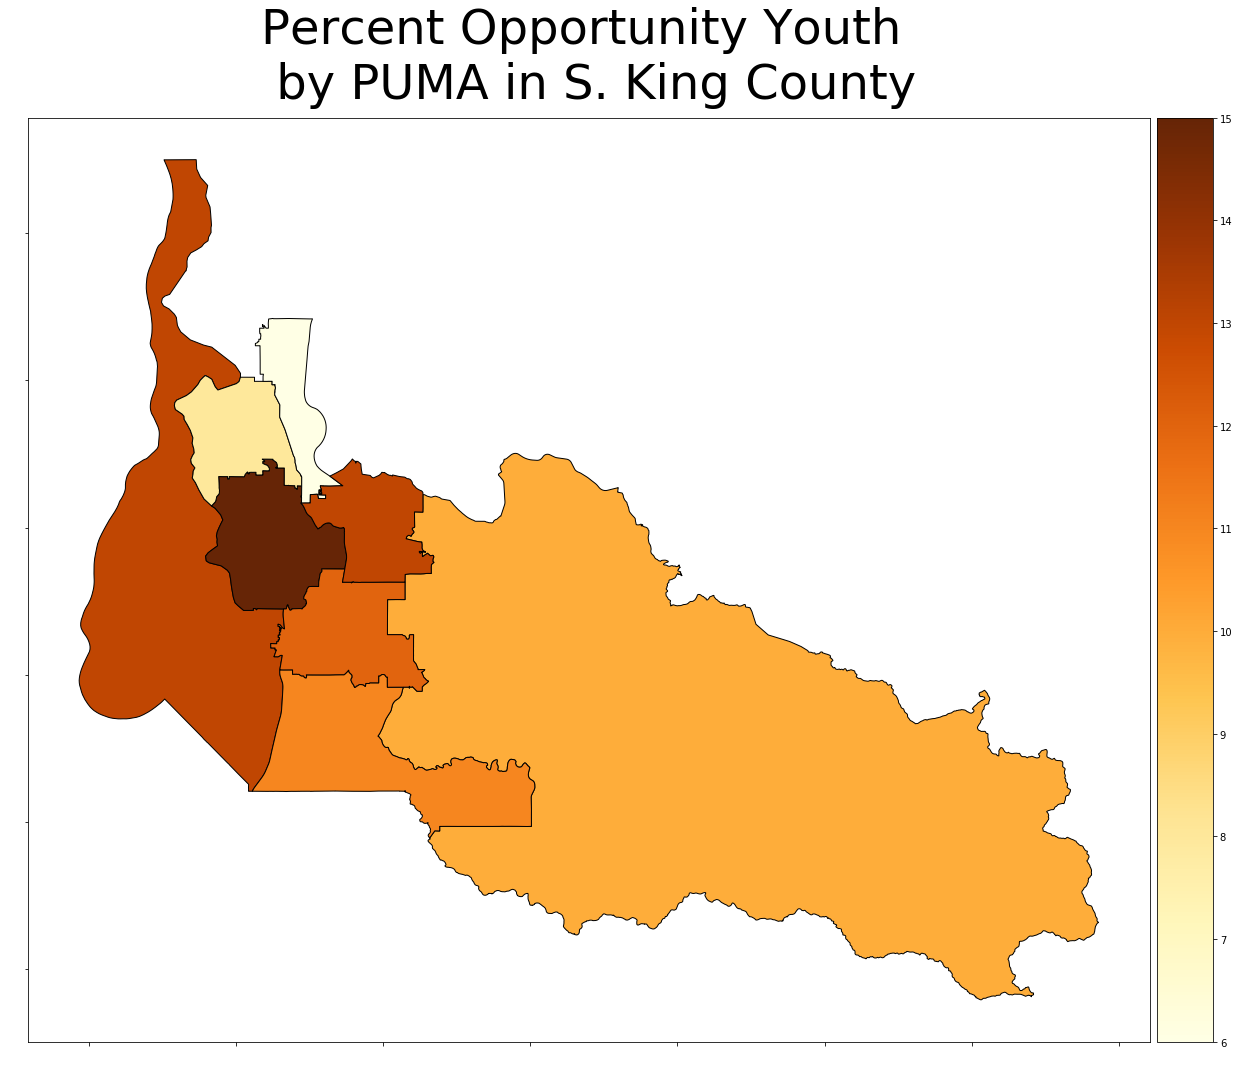

In [12]:
opyouth.make_choropleth_percentOY_map(s_king_df);

## Future Directions

This preliminary exploration of the data is contingent on several assumptions based on the original analysis, mainly the selection of geographic areas in South King Co. and the criteria set forth for identifying opportunity youth. We recommend obtaining the 2014 data and following our methods to ensure direct comparability between the datasets. 

Furthermore, we would like to explore the trends surrouding the decrease of the total youth population in S. King Co. We would suggest mapping youth population across King Co. to test whether youth population has remained steady or grown, but moved out of S. King Co. 

Finally, our finding that there are fewer opportunity youth with college experience suggests that employment opportunities are higher for youth with college degrees. We suggest exploring this trend further by gathering employment data such as employment rates, employment sectors for youths, and the requirements these jobs may have.